<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [17]</a>'.</span>

In [1]:
# Read and process ECCOv4r5 data
# ECCO has specific irregular grids, so a python package has been developed to read and process it.
# The package can be downloaded from https://ecco-v4-python-tutorial.readthedocs.io/ with tutorials

# One thing to note is that ECCO has longitude between -180 and 180,
# but GRACE is from 0 to 360. We may need to make them in the same coordinate system for comparison.

# We also need to make both ECCO and GRACE in the same grid. 
# Interpolate GRACE to ECCO grids for now
# https://xesmf.readthedocs.io/en/stable/notebooks/Curvilinear_grid.html.

In [1]:
import sys
sys.path.append('ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
import os
import numpy as np
from tqdm.auto import tqdm # progress bar
import xarray as xr
import gc
#import xesmf as xe


import warnings
warnings.filterwarnings("ignore")

# Used to reload another notebook if code was updated
from importlib import reload

In [3]:
from config import output_dir, input_dir, input_dir_ecco_v4r5_ext, input_dir_ecco_v4r5_to2019, input_dir_ecco_ctrl, input_dir_ecco_grid
from pathlib import Path
Path(output_dir).mkdir(parents=True, exist_ok=True)

# load ECCO grids

In [4]:
# Load ecco grid into an array with dimensions: longitudes (XC), latitudes (YC), 13 tiles 
eccor5_grid = ecco.load_ecco_grid_nc(input_dir_ecco_grid, 'ECCO-GRID.nc')

# Load ECCOv4r5 OBPNOPAB

In [5]:
# data directory
r5_dir = os.path.join(input_dir_ecco_v4r5_to2019, '')
# list of .meta and .data files in r5_dir
data_list = sorted(os.listdir(r5_dir)) # data_list[0:-1:2] is *.data

In [6]:
# array of months from 1992 to 2020, last month is 2019.91666667
r5_month = np.arange(1992,2020,1/12)

In [7]:
# maskC is a boolean array with dimensions: (k, tile, j, i)

#mask = eccor5_grid.maskC.sel(k=0)
#mask = mask.astype(int)


# maskC is a boolean array with dimensions: (k, tile, j, i)
# Sum the mask values in the k (ocean depth layers) dimension.
mask = np.sum(eccor5_grid.maskC, axis=0)
for i in np.arange(13):
    temp = mask[i,:,:].values
    temp[temp>0] = 1
del i, temp
gc.collect()


22

In [8]:
# pressure each month, 199201 - 201912 for each of 13 90x90 tiles
pb_r5_mon_raw = np.zeros((len(r5_month),13,90,90))*np.nan
maskW = mask
# tqdm shows a progress bar
for i in tqdm(np.arange(len(data_list[0:-1:2]))):
    # read llc compact format binary file and converts to a numpy ndarray of dimension: [N_recs, N_z, N_tiles, llc, llc]
    # 'N_recs' = number of time levels
    # 'N_z' = number of depth levels
    # 'N_tiles' = 13
    # 'llc' = 90
    data = ecco.read_llc_to_tiles(r5_dir, data_list[0::2][i],filetype='>f8',less_output=True)*100;
    data = data*maskW
    
    # pb_rf_mon is 336 months of 13 90x90 tiles   (336, 13, 90, 90)
    pb_r5_mon_raw[i,:,:,:] = data

  0%|          | 0/336 [00:00<?, ?it/s]

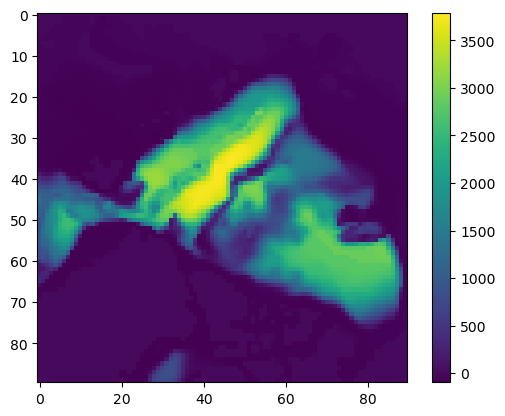

In [11]:
import matplotlib.pyplot as plt

plt.imshow(pb_r5_mon_raw[0,6,:,:])
plt.colorbar()



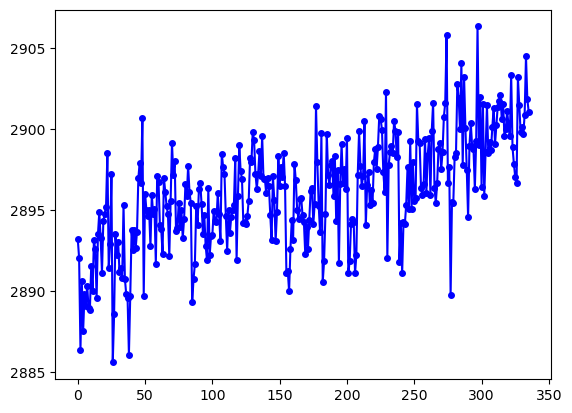

In [12]:
pb_r5_mon_raw[:,6,24,56]
plt.plot(pb_r5_mon_raw[:,6,24,56], linestyle="-", marker="o", color="b", markersize=4)

In [24]:
# Replace zeros with nan.  This only works on type int or positive floating point zeros
pb_r5_mon_raw[pb_r5_mon_raw==0] = np.nan

# This replaces floating point zeros with nan.  Works wtih -0 or -0.00000000e+00
# pb_r5_mon[pb_r5_mon==-0.00000000e+00] = np.nan
pb_r5_mon_raw[pb_r5_mon_raw==-0] = np.nan

# if not os.path.exists(os.path.join(output_dir, 'ecco_199201-201912-raw.nc')):
#     xr.DataArray(pb_r5_mon_raw).to_netcdf(os.path.join(output_dir, 'ecco_199201-201912-raw.nc'))

## Get weight, fraction of total ocean area, in each grid cell

In [19]:
from ipynb.fs.full import Utils
reload(Utils)

# The ra attribute represents the area of each grid cell in the ECCO grid
# global-mean for ocean area, land is zero
total_ocn_area = np.nansum(eccor5_grid.rA*mask) 

def get_weight(ecco_data, file_name):
    # weight is a fraction of total ocean area that each grid cell is
    # .rA provides the horizontal cell area for each grid cell
    weight = eccor5_grid.rA/total_ocn_area
    # Expand the shape of the weight array.  I think 'rA' area is now a dimension, not a variable?
    weight_expanded = np.expand_dims(weight, axis=0)
    # Construct an array by repeating weight_expanded for each month
    weight = np.tile(weight_expanded, (ecco_data.shape[0],1,1,1))

    #xr.DataArray(weight).to_netcdf(os.path.join(output_dir, file_name))
    Utils.to_netcdf_ecco(weight, file_name)

    return weight

In [25]:
def remove_means(ds, weight=None, name='ecco'):
    '''
    Remove global spatial mean and remove the temporal mean from data.

    '''
    if weight is None:
        weight = get_weight(ds, 'ecco_weight.nc')

    # Compute mean pressure by summing (pressure at each cell * cell weight)
    # This is a 1D array
    #if weight.shape == ds.shape:
    
    glob_mean = np.nansum(np.nansum(np.nansum(ds*weight,axis=-1),axis=-1),axis=-1)
        # Global mean pressure is a 4D array over time, tile, tileX, tileY
    # This codde turns the 1D array into 4D
    # values are like -0.00011088, -0.00011114
    glob_mean = np.tile(glob_mean[:,np.newaxis,np.newaxis,np.newaxis],(1,13,90,90))
    
    #else:
    #    glob_mean = (ds * weight.squeeze()).sum(dim=["y", "x"])

    # At each cell, get the diff between pressure and global mean pressure
    # remove ocean spatial mean at each time step
    ds_rm_glob_mean = ds - glob_mean

    xr.DataArray(ds_rm_glob_mean).to_netcdf(os.path.join(output_dir, f'{name}-global-mean-rmved.nc'))

    # NEW:  Remove the temporal mean from each cell.
    # Get time_mean
    time_mean = np.nanmean(ds_rm_glob_mean, axis=0)
    
    return ds_rm_glob_mean - time_mean

In [25]:
weight = get_weight(pb_r5_mon_raw, 'ecco_early_weight.nc')
pb_r5_mon = remove_means(pb_r5_mon_raw, weight, 'ecco')
Utils.to_netcdf_ecco(pb_r5_mon, 'ecco_199201-201912-rm-means.nc')


## ECCO Data 202001 - 202402

In [32]:
# Now do the same thing with data from 202001 to 202402
r5ext_dir = os.path.join(input_dir_ecco_v4r5_ext, '')   
data_list = sorted(os.listdir(r5ext_dir)) 

# Select the files whose name ends with .data
data_files = [f for f in data_list if f.endswith(".data")]

In [33]:
# array of months from Jan 2020 to Feb (2/12) 2024.
r5ext_month = np.arange(2020,2024+1/12+1/16,1/12)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [34]:
# Array dimensions: months, 13 tiles, 90, 90
pb_r5ext_mon = np.zeros((len(r5ext_month),13,90,90))*np.nan

# For each monthly data file, read in data for month, apply mask
for i, file in enumerate(tqdm(data_files)):
    data = ecco.read_llc_to_tiles(r5ext_dir, file, filetype='>f8', less_output=True) * 100;
    data = data*maskW

    # Set data for this month
    pb_r5ext_mon[i,:,:,:] = data

pb_r5ext_mon = pb_r5ext_mon[:, :, :, :]

pb_r5ext_mon[pb_r5ext_mon==0] = np.nan
# This replaces floating point zeros with nan.  Works wtih -0 or -0.00000000e+00
pb_r5ext_mon[pb_r5ext_mon==-0.00000000e+00] = np.nan
pb_r5ext_mon[pb_r5ext_mon==-0] = np.nan

if not os.path.exists(os.path.join(output_dir, 'ecco_202001-202402-raw.nc')):
    xr.DataArray(pb_r5ext_mon).to_netcdf(os.path.join(output_dir, 'ecco_202001-202402-raw.nc'))

100%|██████████| 50/50 [00:00<00:00, 650.00it/s]


In [36]:
# get cell weight for new data
weight_expanded = get_weight(pb_r5ext_mon, 'ecco_late_weight.nc')
normalized_eccco_ext_data = remove_means(pb_r5ext_mon, weight_expanded, 'ecco-ext')

In [18]:
# Quick check making sure that all ECCO weights do match
for i in range(0,39):
    weight_diff = weight[i] - weight_expanded[i]
    #print(np.min(weight_diff))
    #print(np.max(weight_diff))

In [38]:
# Extract coordinates from the grid
# (dim_0: 336, dim_1: 13, dim_2: 90, dim_3: 90)
i = eccor5_grid['i']  # Shape: (90,)
j = eccor5_grid['j']  # Shape: (90,)
tile = eccor5_grid['tile']  # Shape: (13,)
time=(["time"],range(0,len(normalized_eccco_ext_data[:,0,0,0])))

# Create an xarray DataArray from pb_r5_with_ext_mon
pb_ecco = xr.DataArray(
    data=normalized_eccco_ext_data,  # Your numpy array
    dims=['time', 'tile', 'j', 'i'],  # Dimensions
    coords={
        'time': time,
        'tile': tile,
        'j': j,
        'i': i
    },
    name='pb',  # Name of the DataArray
    attrs={'units': 'cm'} 
)

# Convert time indexes to year.decimal
normalized_eccco_ext_data = pb_ecco.assign_coords({
    'time': 2020.0 + (pb_ecco['time'] / 12)  # Convert time to "year.decimal"
})

if not os.path.exists(os.path.join(output_dir, 'ecco_202001-202402-rm-means.nc')):
    normalized_eccco_ext_data.to_netcdf(os.path.join(output_dir, 'ecco_202001-202402-rm-means.nc'))

In [20]:

#del  weight_expanded,total_ocn_area

### Concatenate 199201 - 201912 data with 202001 - 202402 data

In [41]:
# Concat 1992 - 2020 pressure diffs with 2020 - 2023 data
pb_r5_with_ext_mon = np.concatenate((pb_r5_mon,normalized_eccco_ext_data),axis=0)

# Concat months into one array of months
r5_with_ext_month = np.concatenate((r5_month,r5ext_month))


In [42]:
# Save r5_with_ext_month to an xarray dataset

# Extract coordinates from the grid
i = eccor5_grid['i']  # Shape: (90,)
j = eccor5_grid['j']  # Shape: (90,)
tile = eccor5_grid['tile']  # Shape: (13,)
time=(["time"],range(0,len(pb_r5_with_ext_mon[:,0,0,0])))



In [43]:
ds = xr.Dataset(
    data_vars=dict(
        pb=(["time","tile", "j", "i"], pb_r5_with_ext_mon, {"units": "cm"}),
    ),
    coords=dict(
        time=r5_with_ext_month,
        tile=tile,
        j=j,
        i=i
    ),
    attrs=dict(description="ECCO pb, cm", units='cm'),
)

# Save the dataset to a NetCDF file
if not os.path.exists(os.path.join(output_dir, 'pb_ECCO_all_data.nc')):
    ds.to_netcdf(os.path.join(output_dir, 'pb_ECCO_all_data.nc'))


In [44]:
# Dictionary to store variable names and their sizes
variable_sizes = {var: sys.getsizeof(value) for var, value in globals().items() if not var.startswith("_")}

# Print each variable and its size, then delete the var
for var, size in variable_sizes.items():
    #print(f"{var}: {size} bytes")
    del var
gc.collect()

1170